 # Sin曲線を学習してみる

 Sin曲線は [-1,1] の間で規則的に綺麗にカーブを描くので、その曲線の十分な長さの部分から次の値を当てることができるでしょう。

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras as k

(2000,) (2000,)
(2000, 1) (2000, 1)


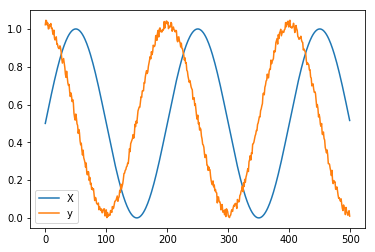

In [97]:
# Sin曲線の1反復あたりのサンプル数
samples_per_cycle = 20 * 10
# 生成するSinサイクル数
number_of_cycles = 10
data_len = samples_per_cycle * number_of_cycles
arange = np.arange(data_len) * 2 * np.pi / samples_per_cycle
X = np.sin(arange) * .5 + .5
y = np.cos(arange) * .5 + .5 + \
    np.random.random_sample((data_len,)) * 0.05
pd.DataFrame({'X': X, 'y': y}).head(500).plot()
print(X.shape, y.shape)
xdim = 1
ydim = 1
X = X.reshape([-1, xdim])
y = y.reshape([-1, ydim])
print(X.shape, y.shape)

seq_len = samples_per_cycle // 10
batch_size = 128
n_epochs = 30
lstm_n_units = 300


def print_params():
  print('''
data_len={}
seq_len={}
batch_size={}
xdim={}
ydim={}
lstm_n_units={}
n_epochs={}
'''.format(data_len, seq_len, batch_size, xdim, ydim,
           lstm_n_units, n_epochs))

# Keras

In [98]:
kgen = k.preprocessing.sequence.TimeseriesGenerator(
    X, y, length=seq_len, batch_size=batch_size)
print(kgen[0][0].shape, kgen[0][1].shape)
assert np.array_equal(kgen[0][0][0], X[0:seq_len])
assert np.array_equal(kgen[0][0][1], X[1:seq_len + 1])
assert np.array_equal(kgen[0][1], y[seq_len:seq_len + batch_size])

(128, 20, 1) (128, 1)


In [99]:
kmodel = k.models.Sequential([
    k.layers.LSTM(lstm_n_units, input_shape=(seq_len, xdim,)),
    k.layers.Dense(ydim), k.layers.Activation('sigmoid'),
])
kmodel.compile(optimizer='rmsprop', loss='mean_squared_error')
print(kmodel.summary())
early_stop = k.callbacks.EarlyStopping(
    monitor='loss',
    patience=4,
    restore_best_weights=True,
    verbose=1)
reduce_lr = k.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=early_stop.patience // 2,
    verbose=1)
callbacks = [reduce_lr, early_stop]
print_params()
kmodel.fit_generator(kgen, epochs=n_epochs, callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
None

data_len=2000
seq_len=20
batch_size=128
xdim=1
ydim=1
lstm_n_units=300
n_epochs=30

Epoch 1/30
16/16 [==============================] - 3s 164ms/step - loss: 0.1229
Epoch 2/30
16/16 [==============================] - 1s 91ms/step - loss: 0.1182
Epoch 3/30
16/16 [==============================] - 1s 92ms/step - loss: 0.1113
Epoch 4/30
16/16 [==============================] - 2s 96ms/step - lo

((1980,), (1980,))

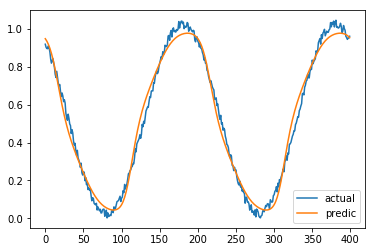

In [100]:
# 学習結果と実際値の比較
pred = kmodel.predict_generator(kgen).flatten()
pd.DataFrame({'actual': y.flatten()[seq_len:],
              'predic': pred.flatten()}).head(
    samples_per_cycle * 2).plot()
pred.shape, y.flatten()[seq_len:].shape